In [1]:
%env CUDA_VISIBLE_DEVICES=0
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

import open3d as o3d
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

from utils import *

env: CUDA_VISIBLE_DEVICES=0
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [3]:
model = VGGT()
_URL = "./model.pt"
model.load_state_dict(torch.load(_URL))
model.eval()
model = model.to(device)

/tmp/ipykernel_111980/2406001790.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(_URL))


In [5]:
path = "/root/autodl-tmp/facescape/mv_image/1_16view"

image_names = sorted(glob.glob(os.path.join(path, "*.jpg")))

In [5]:
import cv2

new_image_names = []
for image_name in image_names:
    image = cv2.imread(image_name)
    if image.shape[0] > image.shape[1]:
        new_image_names.append(image_name)
image_names = new_image_names

In [6]:
# random sample 16 images
import random
image_names = random.sample(image_names, 16)

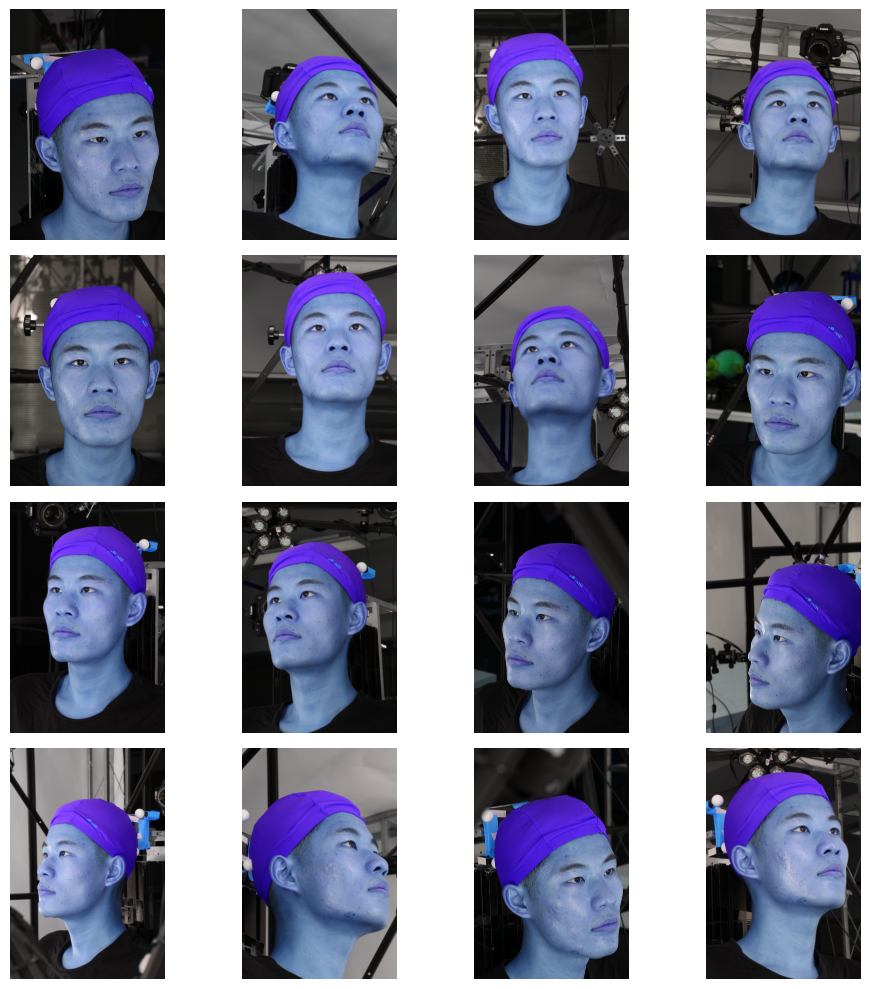

In [6]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image = cv2.imread(image_names[i])
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [15]:
images = load_and_preprocess_images(image_names).to(device)

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)
                
    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    # Predict Point Maps
    point_map, point_conf = model.point_head(aggregated_tokens_list, images, ps_idx)
        
    # Construct 3D Points from Depth Maps and Cameras
    # which usually leads to more accurate 3D points than point map branch
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0), 
                                                                extrinsic.squeeze(0), 
                                                                intrinsic.squeeze(0))

/tmp/ipykernel_361958/1166783532.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


In [8]:
point_all = point_map_by_unprojection.reshape(-1, 3)
color_all = images[0].permute(0, 2, 3, 1).reshape(-1, 3).detach().cpu().numpy()
conf_all = depth_conf[0].reshape(-1,).detach().cpu().numpy()
threshold = np.median(conf_all)
conf_mask = conf_all > threshold
point_all = point_all[conf_mask]
color_all = color_all[conf_mask]

In [205]:
use_scan_points = True
if use_scan_points:
    scan_path = "/root/autodl-tmp/facescape/scan/1_neutral.ply"
    scan_mesh = o3d.io.read_triangle_mesh(scan_path)
    scan_points = np.asarray(scan_mesh.vertices)
    point_all = scan_points
    color_all = np.ones_like(scan_points) * 0.6

In [206]:
augment = True
if augment:
    points_aug = []
    for i in range(5):
        points_aug.append(point_all + np.random.randn(*point_all.shape) * 0.01)
    points_aug = np.concatenate(points_aug, axis=0)
point_all = points_aug if augment else point_all

In [304]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_all)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/points_aug.ply", pcd)

True

In [207]:
# 此时point数量太多了，没法学，sample出30000个点
import random
sample_indices = random.sample(range(point_all.shape[0]), 30000)

points = point_all[sample_indices]
# colors = color_all[sample_indices]

In [208]:
# load target mesh
target_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/mesh/1_neutral_align.ply")
# target_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/result/exp1/1_neutral.ply")
faces = np.asarray(target_mesh.triangles)
vertices = np.asarray(target_mesh.vertices)

In [209]:
point_prob = torch.nn.Parameter(torch.zeros((points.shape[0], vertices.shape[0]),device="cuda"))

In [234]:
feature_mlp = FFMLP(in_dim=3, hidden_dim=256,out_dim=11441,activation=None).to(device)

In [211]:
# prepare optimizer
optimizer = torch.optim.Adam([point_prob], lr=1e-2)

In [235]:
optimizer = torch.optim.Adam(feature_mlp.parameters(), lr=1e-3)

In [5]:
summary_writer = SummaryWriter()

In [213]:
# prepare hyperparameters
epochs = 3000

In [214]:
if type(points) == np.ndarray:
    points = torch.from_numpy(points).to("cuda") # 30000, 3
if type(vertices) == np.ndarray:
    vertices = torch.from_numpy(vertices).to("cuda") # num_vertices, 3

In [70]:
# adust optimizer learning rate with 0.1
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.3 * param_group['lr']

In [16]:
def sample_mesh(points, point_prob_softmax):
    res_indices = np.zeros(point_prob_softmax.shape[1])
    N = points.detach().cpu().numpy().shape[0]
    ps = point_prob_softmax.detach().cpu().numpy()
    for i in range(point_prob_softmax.shape[1]):
        res_indices[i] = np.random.choice(N,p = ps[:,i])
    res_indices = torch.from_numpy(res_indices).long().to(points.device)
    res_points = points[res_indices]
    return res_points

In [215]:
point_prob.shape

torch.Size([30000, 11441])

In [237]:
from tqdm import trange
import random

for epoch in (tbar:=trange(epochs)):
    # compute ours mesh with expectation
    # point_prob_softmax = torch.softmax(point_prob, dim=0) # 30000, num_vertices
    # points_mesh = point_prob_softmax.T @ points.float() # num_vertices, 3
    
    # point_prob_sigmoid = torch.sigmoid(point_prob) # 30000, num_vertices
    # point_prob_sigmoid = feature_mlp(points.float()) # 30000, 11441
    # point_prob_softmax = point_prob_sigmoid / torch.sum(point_prob_sigmoid, dim=0, keepdim=True) # 30000, num_vertices
    # points_mesh = point_prob_softmax.T @ points.float() # num_vertices, 3
    
    point_prob = feature_mlp(points.float()) # 30000, 11441
    point_prob_softmax = torch.softmax(point_prob, dim=0) # 30000, num_vertices
    points_mesh = point_prob_softmax.T @ points.float() # num_vertices, 3
    
    
    # consistency of sample points
    # samples_A = []
    # samples_B = []
    # for i in range(500):
    #     template_index = random.randint(0, points_mesh.shape[0]-1)
    #     sample_A = np.random.choice(points.shape[0], p = point_prob_softmax[:,template_index].detach().cpu().numpy())
    #     sample_B = np.random.choice(points.shape[0], p = point_prob_softmax[:,template_index].detach().cpu().numpy())
    #     samples_A.append(sample_A)
    #     samples_B.append(sample_B)
    # samples_A = torch.from_numpy(np.array(samples_A)).long().to(points.device)
    # samples_B = torch.from_numpy(np.array(samples_B)).long().to(points.device)
    
    # compute loss
    loss_shape = vertice_loss(points_mesh, vertices.float()) * 1000
    loss_reg = torch.mean((point_prob_softmax ** 0.75)) * 0
    
    # loss_consistency = vertice_loss(points[samples_A], points[samples_B]) * 30
    
    loss = loss_shape + loss_reg
    
    
    # optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 and False:
        # save result mesh
        results_mesh = o3d.geometry.TriangleMesh()
        results_mesh.vertices = o3d.utility.Vector3dVector(points_mesh.detach().cpu().numpy())
        results_mesh.triangles = o3d.utility.Vector3iVector(faces)

        # write mesh
        results_mesh.compute_vertex_normals()
        results_mesh.paint_uniform_color([0.7, 0.7, 0.7])

        o3d.io.write_triangle_mesh(f"/root/autodl-tmp/facescape/result/debug/{epoch}.ply", results_mesh)

    
    # print loss
    tbar.set_description(f"loss: {loss.item():.4g}")
    summary_writer.add_scalar("shape loss", loss_shape.item())
    summary_writer.add_scalar("reg loss", loss_reg.item())
    # summary_writer.add_scalar("consistency loss", loss_consistency.item())

  0%|          | 0/3000 [00:00<?, ?it/s]

loss: 0.02727:  16%|█▋        | 493/3000 [00:52<04:28,  9.35it/s]


KeyboardInterrupt: 

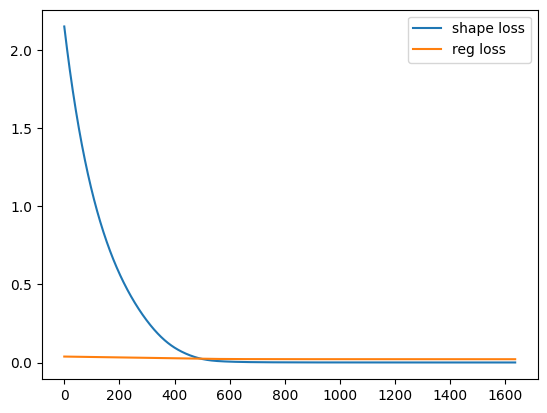

In [627]:
summary_writer.plot(250)

In [587]:
# save result mesh
results_mesh = o3d.geometry.TriangleMesh()
results_mesh.vertices = o3d.utility.Vector3dVector(points_mesh.detach().cpu().numpy())
results_mesh.triangles = o3d.utility.Vector3iVector(faces)

# write mesh
results_mesh.compute_vertex_normals()
results_mesh.paint_uniform_color([0.7, 0.7, 0.7])

o3d.io.write_triangle_mesh("/root/autodl-tmp/facescape/result/1_neutral.ply", results_mesh)

True

In [588]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/sample_points.ply", pcd)

pcd.points = o3d.utility.Vector3dVector(points_mesh.detach().cpu().numpy())
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/points_mesh.ply", pcd)

True

In [595]:
np.argsort(point_prob_softmax[:, 5096].detach().cpu().numpy())

array([ 8046, 19680, 18512, ..., 22234, 27706, 10211])

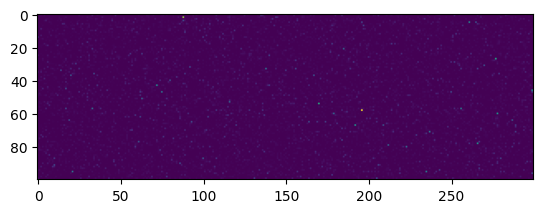

In [647]:
template_ind = 7957

from matplotlib import cm
from matplotlib import pyplot as plt
def apply_color_map(data,cmap = 'viridis', vmin=None, vmax=None):
    data = np.array(data)
    if vmin is None:
        v_min = np.min(data)
    if vmax is None:
        v_max = np.max(data)
    return getattr(cm,cmap)(plt.Normalize(vmin,vmax)(data))[...,:3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())

color = point_prob_softmax[:, template_ind].detach().cpu().numpy()
color = apply_color_map(color ** (1/3))
pcd.colors = o3d.utility.Vector3dVector(color)

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/sample_points_color.ply", pcd)
plt.imshow(color.reshape(100, 300, 3))

#### 用GT的depth和camera pose，假装VGGT能提供非常准的这俩玩意，然后用VGGT提供的feature尝试做网络训练，回归出mesh

In [4]:
import random
import cv2

debug = False

idx = "1"

base_path = "/root/autodl-tmp/facescape"
img_path = os.path.join(base_path, "mv_image", idx)
depth_path = os.path.join(base_path, "depth", idx)
mask_path = os.path.join(base_path, "mask", idx)
params_path = os.path.join(base_path, "params", idx)

n_imgs = len(os.listdir(img_path))

In [5]:
def load_data(load_indices):
    depth_map = []
    extrinsic = []
    intrinsic = []
    images = []
    masks = []

    for load_index in load_indices:
        if False:
            img, depth, mask, extr, intr = data_cache[load_index]
        else:
            img = cv2.imread(os.path.join(img_path, f"{load_index}.png"))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.resize(img, (518, round(2592/1728*518)))
            # img = img[130:130+518, 0:518]
            depth = np.load(os.path.join(depth_path, f"{load_index}.npy"))
            # depth = cv2.resize(depth, (518, round(2592/1728*518)))
            # depth = depth[130:130+518, 0:518]
            mask = np.load(os.path.join(mask_path, f"{load_index}.npy"))
            # mask = cv2.resize(mask, (518, round(2592/1728*518)))
            # mask = mask[130:130+518, 0:518]
            params = np.load(os.path.join(params_path, f"{load_index}.npz"))
            extr = params["extr"]
            intr = params["intr"]
            # intr = intr * 518 / 1728
            # intr[1,2] = intr[1,2] - 130
            # data_cache[load_index] = (img, depth, mask, extr, intr)
        depth_map.append(depth)
        extrinsic.append(extr)
        intrinsic.append(intr)
        images.append(img)
        masks.append(mask)

    images = np.array(images)
    images = images / 255.
    masks = np.array(masks)
    depth_map = np.array(depth_map)
    extrinsic = np.array(extrinsic)
    intrinsic = np.array(intrinsic)
    return images, depth_map, extrinsic, intrinsic, masks
    
# images = torch.from_numpy(images).to(device).float()
# depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
# extrinsic = torch.from_numpy(extrinsic).to(device)
# intrinsic = torch.from_numpy(intrinsic).to(device)

all_images, all_depth_maps, all_extrinsics, all_intrinsics, all_masks = load_data(list(range(n_imgs)))

def load_data(load_indices):
    load_indices = list(load_indices)
    images = all_images[load_indices]
    depth_maps = all_depth_maps[load_indices]
    extrinsics = all_extrinsics[load_indices]
    intrinsics = all_intrinsics[load_indices]
    masks = all_masks[load_indices]
    return images, depth_maps, extrinsics, intrinsics, masks

In [6]:
def process_data(images, depth_map, extrinsic, intrinsic, masks, model, num_sample=30000):
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            images = images[None]  # add batch dimension
            aggregated_tokens_list, ps_idx = model.aggregator(images)
        feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images, ps_idx)[0]
        del images
        feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
    
    feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
    
    points = unproject_depth_map_to_point_map(depth_map,
                                        extrinsic, 
                                        intrinsic) # 16, 518, 518, 3
    points = points * 4
    
    if num_sample == -1:
        return points, feature_maps
    
    points = points[masks.detach().cpu().numpy() > 0] # K,3
    
    k1 = points.shape[0]
    
    sample_indices = random.sample(range(points.shape[0]), num_sample)
    
    points = points[sample_indices] # 30000,3

    points = torch.from_numpy(points).to(device)
    
    feature_maps = feature_maps[masks>0] # K,128
    k2 = feature_maps.shape[0]
    assert k1 == k2
    feature_maps = feature_maps[sample_indices] # 30000,128
    
    return points, feature_maps

In [28]:
# 把GT的depth和camera pose重投影到三维空间，并保存成点云，看看是否正确
if debug:
    import random
    load_indices = random.sample(range(0, n_imgs), 16)
    images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)
    depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
    extrinsic = torch.from_numpy(extrinsic).to(device)
    intrinsic = torch.from_numpy(intrinsic).to(device)
    point = unproject_depth_map_to_point_map(depth_map, 
                                    extrinsic, 
                                    intrinsic)
    point = point[masks > 0]
    sample_indices = random.sample(range(point.shape[0]), 30000)
    point = point[sample_indices]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point * 4)
    o3d.io.write_point_cloud("./test.ply", pcd)
    print("point shape:", point.shape)

In [7]:
load_indices_samples = set()
while True:
    samples = list(range(n_imgs))
    random.shuffle(samples)
    samples = samples[:16]
    samples = sorted(samples)
    load_indices_samples.add(tuple(samples))
    if len(load_indices_samples) == 1000:
        break
load_indices_samples = list(load_indices_samples)
train_indices = load_indices_samples[:800]
val_indices = load_indices_samples[800:900]
test_indices = load_indices_samples[900:]

In [69]:
from tqdm import trange
feature_maps_avg = np.zeros((n_imgs, 518, 518, 128), dtype=np.float32)
n_feature_maps = np.zeros((n_imgs), dtype=np.float32)

for i in trange(800):
    load_indices = train_indices[i]
    images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)
    images = torch.from_numpy(images).to(device).float()
    depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
    extrinsic = torch.from_numpy(extrinsic).to(device)
    intrinsic = torch.from_numpy(intrinsic).to(device)
    images = images.permute(0, 3, 1, 2)
    points, feature_maps_ = process_data(images, depth_map, extrinsic, intrinsic, masks, model, num_sample=-1)
    for j in range(len(load_indices)):
        index = load_indices[j]
        feature_maps_avg[index] = feature_maps_avg[index] * n_feature_maps[index] / (n_feature_maps[index]+1) + feature_maps_[j].detach().cpu().numpy()/ (n_feature_maps[index]+1)
        n_feature_maps[index] += 1

100%|██████████| 800/800 [1:39:34<00:00,  7.47s/it]


In [8]:
all_points = unproject_depth_map_to_point_map(torch.from_numpy(all_depth_maps).to(device).unsqueeze(-1),
                                    torch.from_numpy(all_extrinsics).to(device), 
                                    torch.from_numpy(all_intrinsics).to(device)) # 16, 518, 518, 3
all_points = all_points * 4

In [71]:
all_points = all_points[all_masks > 0] # K,3
all_features = feature_maps_avg[all_masks > 0] # K,128

In [75]:
# import nearest neighbor using sklearn
from sklearn.neighbors import NearestNeighbors
class PointField():
    def __init__(self, points, features, k):
        self.points = points
        self.features = features
        self.k = k
        self.knn = NearestNeighbors(n_neighbors=self.k)
        self.knn.fit(self.points)
        
    def query(self, points):
        # find the nearest k neighbors
        distances, indices = self.knn.kneighbors(points)
        # get the features of the nearest k neighbors
        features = self.features[indices]
        # using inverse distance weighting to get the final features
        weights = 1 / (distances + 1e-8)
        weights = weights / np.sum(weights, axis=1, keepdims=True)
        features = np.sum(features * weights[..., np.newaxis], axis=1)
        return features
        

In [89]:
pointField = PointField(all_points, all_features, k=10)

In [81]:
# save all_points and all_features
np.save("/root/autodl-tmp/facescape/result/all_points.npy", all_points)
np.save("/root/autodl-tmp/facescape/result/all_features.npy", all_features)

In [8]:
all_points = np.load("/root/autodl-tmp/facescape/result/nose_featureMLP_randomSample/all_points.npy")
all_features = np.load("/root/autodl-tmp/facescape/result/nose_featureMLP_randomSample/all_features.npy")

In [9]:
%load_ext autoreload
%autoreload 2
from networks import *

In [37]:
# first learn a feature field
from encoding import MultiResHashGrid
grid = MultiResHashGrid(dim=3,n_features_per_level=8).to(device)
ffmlp = FFMLP(in_dim=3, hidden_dim=256, out_dim=128,activation=None).to(device)
transform = TransformLayer().to(device)
field_mlp = torch.nn.Sequential(
    ffmlp
)
optimizer = torch.optim.Adam(field_mlp.parameters(), lr=1e-3)

In [38]:
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore")

epochs = 4000

for epoch in (tbar:=trange(epochs)):
    load_indices = random.choice(train_indices)
    
    images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)

    masks = torch.from_numpy(masks).to(device)
    images = torch.from_numpy(images).to(device).float()
    depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
    extrinsic = torch.from_numpy(extrinsic).to(device)
    intrinsic = torch.from_numpy(intrinsic).to(device)
    
    images = images.permute(0, 3, 1, 2)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            images = images[None]  # add batch dimension
            aggregated_tokens_list, ps_idx = model.aggregator(images)
        feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images, ps_idx)[0]
        del images
        feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
    
    
    feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
    
    points = unproject_depth_map_to_point_map(depth_map,
                                        extrinsic, 
                                        intrinsic) # 16, 518, 518, 3
    points = points * 4
    
    points = points[masks.detach().cpu().numpy() > 0] # K,3
    
    k1 = points.shape[0]
    
    sample_indices = random.sample(range(points.shape[0]), 30000)
    
    points = points[sample_indices] # 30000,3

    points = torch.from_numpy(points).to(device)
    
    feature_maps = feature_maps[masks>0] # K,128
    k2 = feature_maps.shape[0]
    assert k1 == k2
    feature_maps = feature_maps[sample_indices] # 30000,128
    
    predict_feature_maps = field_mlp(points.float()/10) # 30000,128
    
    loss = torch.nn.functional.mse_loss(predict_feature_maps, feature_maps)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    tbar.set_description(f"loss: {loss.item():.4g}")

  0%|          | 0/4000 [00:00<?, ?it/s]

loss: 0.4574: 100%|██████████| 4000/4000 [2:28:39<00:00,  2.23s/it]  


In [80]:
load_indices = random.choice(train_indices)

images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)

masks = torch.from_numpy(masks).to(device)
images = torch.from_numpy(images).to(device).float()
depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
extrinsic = torch.from_numpy(extrinsic).to(device)
intrinsic = torch.from_numpy(intrinsic).to(device)

images = images.permute(0, 3, 1, 2)

with torch.no_grad():
    points, feature_maps = process_data(images, depth_map, extrinsic, intrinsic, masks, model)

feature_maps_np = feature_maps.detach().cpu().numpy()
# using PCA to reduce the dimension of feature maps
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# pca.fit(feature_maps_np)
# feature_maps_np = pca.transform(feature_maps_np)
feature_maps_np = feature_maps_np[:,0:3]
color = feature_maps_np
# normalize color to [0,1]
color = (color + 5) / (10)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())
pcd.colors = o3d.utility.Vector3dVector(color)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/feature_maps.ply", pcd)

True

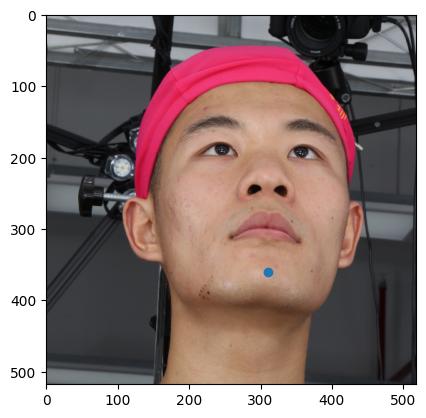

In [39]:
plt.imshow(all_images[13])
plt.scatter(310,360)

In [45]:
fs = []
ps = []
from tqdm import trange

for i in trange(50):
    load_indices = random.choice(train_indices)

    while 13 not in load_indices:
        load_indices = random.choice(train_indices)

    # move 3 to the first
    load_indices = list(load_indices)
    load_indices.remove(13)
    load_indices = [13] + load_indices
    load_indices = tuple(load_indices)

    images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)

    masks = torch.from_numpy(masks).to(device)
    images = torch.from_numpy(images).to(device).float()
    depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
    extrinsic = torch.from_numpy(extrinsic).to(device)
    intrinsic = torch.from_numpy(intrinsic).to(device)

    images = images.permute(0, 3, 1, 2)
    
    points, feature_maps = process_data(images, depth_map, extrinsic, intrinsic, masks, model, num_sample=-1)

    feature_maps_np = feature_maps.detach().cpu().numpy()
    f = feature_maps_np[0, 360, 310, :]
    fs.append(f)
    ps.append(points[0, 360, 310, :])

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_50864/3560354935.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):
100%|██████████| 50/50 [02:46<00:00,  3.32s/it]


In [36]:
f1 = np.array(fs)

In [46]:
f2 = np.array(fs)

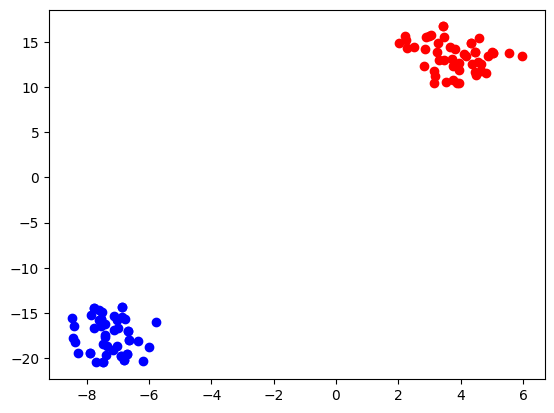

In [50]:
# use tsne to reduce the dimension of f1 and f2 to 2
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=10)
tsne.fit(np.concatenate([f1, f2], axis=0))
f1_2d = tsne.embedding_[0:50]
f2_2d = tsne.embedding_[50:100]
plt.scatter(f1_2d[:, 0], f1_2d[:, 1], c='r')
plt.scatter(f2_2d[:, 0], f2_2d[:, 1], c='b')

In [68]:
feature_mlp = torch.nn.Sequential(
    FFMLP(in_dim=128,hidden_dim=512,out_dim=3985,activation=None).to(device)
)

In [13]:
from encoding import MultiResHashGrid
grid = MultiResHashGrid(dim=3,n_features_per_level=8).to(device)

In [69]:
optimizer = torch.optim.Adam(feature_mlp.parameters(), lr=1e-3)

# optimizer = torch.optim.Adam([
#     {"params": feature_mlp.parameters(), "lr": 1e-3},
#     {"params": grid.parameters(), "lr": 1e-3},
# ], lr=1e-3)

In [12]:
gt_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/mesh/nose.ply")
vertices = np.asarray(gt_mesh.vertices)
# vertices = vertices[[5096]]
# vertices = vertices[[5096,9975,5693]]
vertices = torch.from_numpy(vertices).to(device)

In [70]:
summary_writer = SummaryWriter()

In [14]:
gt_scan = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/scan/1.ply")

In [71]:
from tqdm import tqdm, trange
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

epochs = 4000

for epoch in (tbar:=trange(epochs)):
    load_indices = random.choice(train_indices)
    
    # images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)

    # # masks = torch.from_numpy(masks).to(device)
    # images = torch.from_numpy(images).to(device).float()
    # # depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
    # # extrinsic = torch.from_numpy(extrinsic).to(device)
    # # intrinsic = torch.from_numpy(intrinsic).to(device)
    
    # images = images.permute(0, 3, 1, 2)
    
    # with torch.no_grad():
    #     with torch.cuda.amp.autocast(dtype=dtype):
    #         images = images[None]  # add batch dimension
    #         aggregated_tokens_list, ps_idx = model.aggregator(images)
    #     feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images, ps_idx)[0]
    #     del images
    #     feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
    #     feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
    #     feature_maps = feature_maps.detach().cpu().numpy()
        
    # points = all_points[list(load_indices)]
    
    # points = points[masks > 0] # K,3
    
    # sample_indices = random.sample(range(points.shape[0]), 30000)
    
    # points = points[sample_indices] # 30000,3
    
    sample_indices = random.sample(range(all_points.shape[0]), 30000)
    points = all_points[sample_indices] # 30000,3
    
    
    # points_scan = gt_scan.sample_points_uniformly(30000)
    # points_scan = np.asarray(points_scan.points)
    # add noise
    # points += np.random.randn(*points.shape) * 0.01
    # nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points_scan)
    # distances, indices = nbrs.kneighbors(points)
    # points = points_scan[indices.flatten()]
    
    # points = points_scan
    
    

    points = torch.from_numpy(points).to(device)
    
    # feature_maps = feature_maps[masks>0] # K,128
    # feature_maps = feature_maps[sample_indices] # 30000,128
    # feature_maps = torch.from_numpy(feature_maps).to(device)
    
    
    feature_maps = all_features[sample_indices] # 30000,128
    feature_maps = torch.from_numpy(feature_maps).to(device)
    
    # feature_maps = points.float() / 10 # -1,1
    
    # feature_maps = feature_maps / 2 + 0.5 # 0,1
    # feature_maps = grid(feature_maps)
    
    # feature_maps = pointField.query(points_scan)
    # feature_maps = torch.from_numpy(feature_maps).to(device).float()
    

    probability_maps = feature_mlp(feature_maps) # 30000,1
    
    # normalize probability maps
    # probability_maps = probability_maps / torch.sum(probability_maps, dim=0, keepdim=True) # 30000,1
    
    probability_maps = torch.softmax(probability_maps, dim=0) # 30000,1
    
    
    predict_vertices = probability_maps.T @ points.float() # 1,3
    
    loss = vertice_loss(predict_vertices, vertices.float()) * 1000
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    tbar.set_description(f"loss: {loss.item():.4g}")
    
    summary_writer.add_scalar("loss", loss.item())
    
    

  0%|          | 0/4000 [00:00<?, ?it/s]

loss: 0.01113: 100%|██████████| 4000/4000 [06:29<00:00, 10.27it/s] 


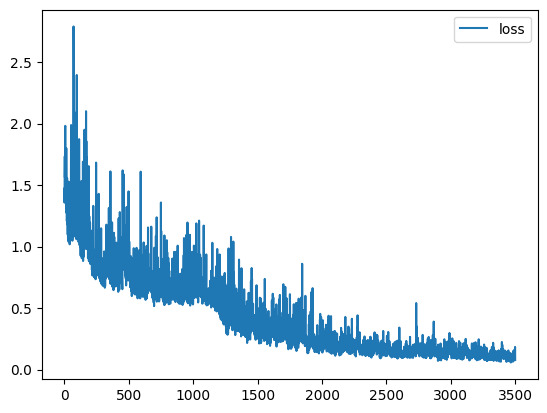

In [25]:
summary_writer.plot(500)

In [76]:
load_indices = random.choice(test_indices)

# images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)

# # masks = torch.from_numpy(masks).to(device)
# images = torch.from_numpy(images).to(device).float()
# # depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
# # extrinsic = torch.from_numpy(extrinsic).to(device)
# # intrinsic = torch.from_numpy(intrinsic).to(device)

# images = images.permute(0, 3, 1, 2)

# with torch.no_grad():
#     with torch.cuda.amp.autocast(dtype=dtype):
#         images = images[None]  # add batch dimension
#         aggregated_tokens_list, ps_idx = model.aggregator(images)
#     feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images, ps_idx)[0]
#     del images
#     feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
#     feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
#     feature_maps = feature_maps.detach().cpu().numpy()
    
# points = all_points[list(load_indices)]

# points = points[masks > 0] # K,3

# sample_indices = random.sample(range(points.shape[0]), 30000)

# points = points[sample_indices] # 30000,3

sample_indices = random.sample(range(all_points.shape[0]), 30000)
points = all_points[sample_indices] # 30000,3


# points_scan = gt_scan.sample_points_uniformly(30000)
# points_scan = np.asarray(points_scan.points)
# add noise
# points += np.random.randn(*points.shape) * 0.01
# nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points_scan)
# distances, indices = nbrs.kneighbors(points)
# points = points_scan[indices.flatten()]

# points = points_scan



points = torch.from_numpy(points).to(device)

# feature_maps = feature_maps[masks>0] # K,128
# feature_maps = feature_maps[sample_indices] # 30000,128
# feature_maps = torch.from_numpy(feature_maps).to(device)


feature_maps = all_features[sample_indices] # 30000,128
feature_maps = torch.from_numpy(feature_maps).to(device)

# feature_maps = points.float() / 10 # -1,1

# feature_maps = feature_maps / 2 + 0.5 # 0,1
# feature_maps = grid(feature_maps)

# feature_maps = pointField.query(points_scan)
# feature_maps = torch.from_numpy(feature_maps).to(device).float()


probability_maps = feature_mlp(feature_maps) # 30000,1

# normalize probability maps
# probability_maps = probability_maps / torch.sum(probability_maps, dim=0, keepdim=True) # 30000,1

probability_maps = torch.softmax(probability_maps, dim=0) # 30000,1


predict_vertices = probability_maps.T @ points.float() # 1,3

loss = vertice_loss(predict_vertices, vertices.float()) * 1000

print(loss.item())

0.012031961232423782


In [77]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())

pcd_vertices = o3d.geometry.PointCloud()
pcd_vertices.points = o3d.utility.Vector3dVector(predict_vertices.detach().cpu().numpy())

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/sample_points.ply", pcd)
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/predict_vertices.ply", pcd_vertices)

True

In [79]:
predict_mesh = o3d.geometry.TriangleMesh()
predict_mesh.vertices = o3d.utility.Vector3dVector(predict_vertices.detach().cpu().numpy())
predict_mesh.triangles = o3d.utility.Vector3iVector(gt_mesh.triangles)
predict_mesh.compute_vertex_normals()
predict_mesh.paint_uniform_color([0.7, 0.7, 0.7])
o3d.io.write_triangle_mesh("/root/autodl-tmp/facescape/result/predict_mesh.ply", predict_mesh)

True

In [52]:
# save model
torch.save(feature_mlp.state_dict(), "/root/autodl-tmp/facescape/result/feature_mlp.pth")

In [96]:
# view the importance sampling
# ref_points = gt_scan.sample_points_uniformly(60000)
# ref_points = np.asarray(ref_points.points)
count_ref_points = np.zeros((ref_points.shape[0], 1))
for i in trange(100):
    load_indices = random.choice(train_indices)
    images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)
    masks = torch.from_numpy(masks).to(device)
    images = torch.from_numpy(images).to(device).float()
    depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
    extrinsic = torch.from_numpy(extrinsic).to(device)
    intrinsic = torch.from_numpy(intrinsic).to(device)
    
    points = unproject_depth_map_to_point_map(depth_map,
                                        extrinsic, 
                                        intrinsic) # 16, 518, 518, 3
    points = points * 4
    
    points = points[masks.detach().cpu().numpy() > 0] # K,3
    
    sample_indices = random.sample(range(points.shape[0]), 30000)
    
    points = points[sample_indices] # 30000,3
    
    points = gt_scan.sample_points_uniformly(30000)
    points = np.asarray(points.points)

    # using torch cdist
    with torch.no_grad():
        dist_matrix = torch.cdist(torch.from_numpy(ref_points).float().to(device), torch.from_numpy(points).float().to(device)) # 30000,30000
        dist_matrix = dist_matrix.detach().cpu().numpy()
    threshold = 0.03
    # get the number of each ref point that has distance < threshold
    count = np.sum(dist_matrix < threshold, axis=1) # 100000,1
    count_ref_points += count.reshape(-1, 1) # 100000,1
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [12:09<00:00,  7.29s/it]


In [97]:
from matplotlib import cm
from matplotlib import pyplot as plt
def apply_color_map(data,cmap = 'viridis', vmin=None, vmax=None):
    data = np.array(data)
    if vmin is None:
        v_min = np.min(data)
    if vmax is None:
        v_max = np.max(data)
    return getattr(cm,cmap)(plt.Normalize(vmin,vmax)(data))[...,:3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(ref_points)

color = count_ref_points.reshape(-1)
color = apply_color_map(color,vmax=10000,vmin=0)
pcd.colors = o3d.utility.Vector3dVector(color)

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/sample_points_color.ply", pcd)

True

(array([ 214.,  269.,  296.,  240.,  294.,  308.,  421.,  460.,  606.,
         649.,  590.,  682.,  754.,  925., 1055., 1105.,  976.,  950.,
        1026., 1080., 1115., 1148., 1051., 1036.,  998.,  935.,  784.,
         736.,  643.,  736.,  862.,  901.,  805.,  664.,  632.,  686.,
         688.,  756.,  807.,  747.,  713.,  750.,  803.,  703.,  804.,
         732.,  731.,  754.,  837.,  706.,  710.,  668.,  646.,  643.,
         650.,  618.,  694.,  648.,  754.,  772.,  671.,  703.,  611.,
         625.,  593.,  559.,  546.,  601.,  600.,  641.,  740.,  757.,
         732.,  670.,  619.,  518.,  489.,  545.,  503.,  444.,  448.,
         405.,  349.,  320.,  293.,  271.,  249.,  214.,  188.,  183.,
         189.,  160.,  150.,  121.,  110.,   86.,   47.,   51.,   22.,
          11.]),
 array([  11.  ,   95.79,  180.58,  265.37,  350.16,  434.95,  519.74,
         604.53,  689.32,  774.11,  858.9 ,  943.69, 1028.48, 1113.27,
        1198.06, 1282.85, 1367.64, 1452.43, 1537.22, 1622.01

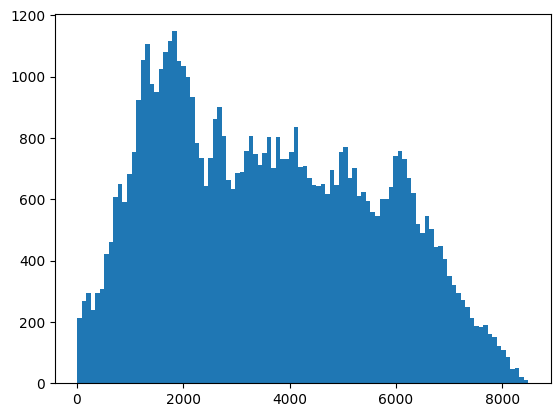

In [93]:
plt.hist(count_ref_points.reshape(-1), bins=100)

(array([4.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 6.000e+00,
        9.000e+00, 2.200e+01, 2.700e+01, 2.100e+01, 3.600e+01, 4.500e+01,
        5.300e+01, 8.100e+01, 9.900e+01, 1.180e+02, 1.740e+02, 1.930e+02,
        2.670e+02, 3.740e+02, 5.010e+02, 6.220e+02, 7.720e+02, 1.018e+03,
        1.247e+03, 1.568e+03, 1.773e+03, 1.920e+03, 2.373e+03, 2.643e+03,
        2.944e+03, 3.116e+03, 3.343e+03, 3.506e+03, 3.394e+03, 3.264e+03,
        2.993e+03, 2.814e+03, 2.626e+03, 2.379e+03, 2.146e+03, 1.864e+03,
        1.536e+03, 1.220e+03, 1.047e+03, 9.280e+02, 7.670e+02, 6.620e+02,
        5.870e+02, 4.350e+02, 3.850e+02, 3.200e+02, 2.760e+02, 2.160e+02,
        1.640e+02, 1.460e+02, 1.240e+02, 1.010e+02, 8.900e+01, 7.600e+01,
        6.000e+01, 5.500e+01, 4.800e+01, 3.400e+01, 2.700e+01, 2.700e+01,
        2.700e+01, 2.100e+01, 2.500e+01, 2.400e+01, 1.100e+01, 2.800e+01,
        2.000e+01, 1.400e+01, 1.600e+01, 1.600e+01, 9.000e+00, 1.300e+01,
        2.000e+00, 1.000e+01, 4.000e+0

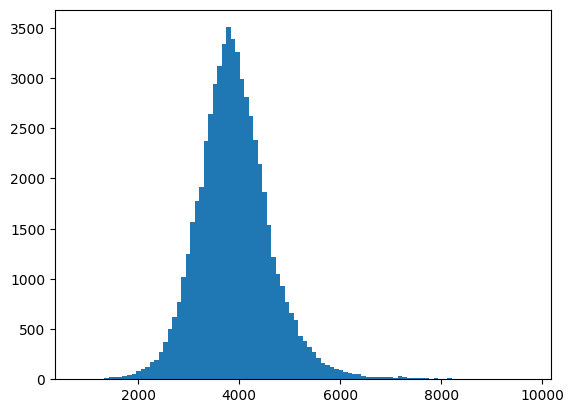

In [99]:
plt.hist(count_ref_points.reshape(-1), bins=100)

In [24]:
# save images
for i in range(16):
    image = images[0][i].detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)
    image = image[:,:,::-1]
    cv2.imwrite(f"/root/autodl-tmp/facescape/result/exp_5096_9975_5693/imgs/image_{i}.png", image)

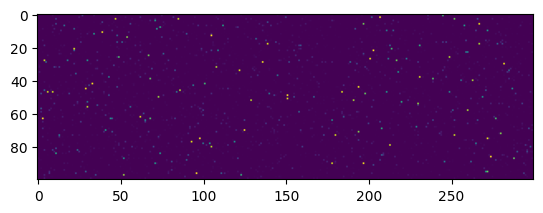

In [30]:
template_ind = 2

from matplotlib import cm
from matplotlib import pyplot as plt
def apply_color_map(data,cmap = 'viridis', vmin=None, vmax=None):
    data = np.array(data)
    if vmin is None:
        v_min = np.min(data)
    if vmax is None:
        v_max = np.max(data)
    return getattr(cm,cmap)(plt.Normalize(vmin,vmax)(data))[...,:3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())

color = probability_maps[:, template_ind].detach().cpu().numpy()
color = apply_color_map(color ** (1/3))
pcd.colors = o3d.utility.Vector3dVector(color)

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/sample_points_color.ply", pcd)
plt.imshow(color.reshape(100, 300, 3))

#### toy实验，4个点，ABCD，拟合一个很靠近A的点

In [353]:
points = [
    [0.,0.,0.],
    [0.,1.,0.],
    [1.,0.,0.],
    [1.,1.,0.]
]
points = np.array(points)

In [359]:
vertices = [
    [0.9,0.9,0.],
    [0.9,0.9,0.],
    [0.4,0.6,0.],
    [0.8,0.6,0.]
]
vertices = np.array(vertices)

In [360]:
# points = torch.from_numpy(points).to("cuda") # 4, 3
vertices = torch.from_numpy(vertices).to("cuda") # 1, 3

In [361]:
point_prob = torch.nn.Parameter(torch.zeros((points.shape[0], vertices.shape[0]),device="cuda"))
optimizer = torch.optim.Adam([point_prob], lr=1e-2)
summary_writer = SummaryWriter()

In [362]:
point_prob_softmax = torch.softmax(point_prob, dim=0) # 30000, num_vertices
points_mesh = point_prob_softmax.T @ points.float() # num_vertices, 3

# compute loss
loss_shape = vertice_loss(points_mesh, vertices.float())
print(loss_shape.item())

0.18999998271465302


In [363]:
for epoch in (tbar:=trange(epochs)):
    # compute ours mesh with expectation
    point_prob_softmax = torch.softmax(point_prob, dim=0) # 30000, num_vertices
    points_mesh = point_prob_softmax.T @ points.float() # num_vertices, 3
    
    # compute loss
    loss_shape = vertice_loss(points_mesh, vertices.float())
    loss_reg = torch.mean((point_prob_softmax ** 0.75)) * 0
    
    loss = loss_shape
    
    
    # optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # print loss
    tbar.set_description(f"loss: {loss.item():.4g}")
    summary_writer.add_scalar("shape loss", loss_shape.item())

loss: 7.519e-12: 100%|██████████| 1000/1000 [00:03<00:00, 298.02it/s]


In [365]:
point_prob_softmax

tensor([[0.0641, 0.0641, 0.1945, 0.1013],
        [0.0359, 0.0359, 0.4055, 0.0987],
        [0.0359, 0.0359, 0.2055, 0.2987],
        [0.8641, 0.8641, 0.1945, 0.5013]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [258]:
points_mesh

tensor([[0.9000, 0.8999, 0.0000],
        [0.8999, 0.9000, 0.0000],
        [0.5000, 0.5000, 0.0000]], device='cuda:0', grad_fn=<MmBackward0>)